In [1]:
#أستدعاء المكتبات 

import tweepy    #مكتبة تويبي للربط مع تويتر وجمع البيانات
import pandas as pd  #  مكتبة بانداز للتعامل مع الجداول والداتافريم
import re  # هذه المكتبة سوف نستعملها في ازالة الرموز 
import jsonpickle #  لتحويل البيانات التي يتم جلبها من تويتر الى صيغة json 
import string # مكتبة سترينق للتعامل مع النصوص 

import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\razah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read data

In [2]:
output = pd.read_csv("lucidya.csv")
output.head(10)

,Tweet_id,sentiment,text
0,1221875106206638080,Positive,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...
1,1221884257490042887,Neutral,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير..."
2,1226422627436310528,Positive,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...
3,1221880820815798277,Positive,@Mo_Fat7 النهضة في فتيل 😂
4,1221884400377499651,Neutral,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...
5,1221881406168731649,Neutral,@adalfahadduwail أبي أعرف الحاكم العربي المسلم...
6,1221882066561830912,Positive,ثقي قلباً وقالباً معاكِ وفخورين فيكِ وين مارحت...
7,1221882047691657217,Neutral,@sarmadbouchamou @DimaSadek في الخطاب تبع سليم...
8,1221880371773673474,Neutral,@FofaMahmouddd مفيش الكلام ده في الزمن
9,1226410076623245313,Neutral,@elm عندي مشكله لما تبي اجدد إقامة عامل حاولت ...


In [3]:
output.shape

(32186, 3)

In [4]:
output = output.drop_duplicates(subset="text")
output.shape

(32001, 3)

In [5]:
output = output.reset_index(drop=True)
output

,Tweet_id,sentiment,text
0,1221875106206638080,Positive,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...
1,1221884257490042887,Neutral,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير..."
2,1226422627436310528,Positive,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...
3,1221880820815798277,Positive,@Mo_Fat7 النهضة في فتيل 😂
4,1221884400377499651,Neutral,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...
...,...,...,...
31996,197552168667054080,Neutral,#صباح_العربية عمره تجاوز المئة وخطف بطولة العا...
31997,1254571322321129474,Neutral,@SaudiMOH عندي وصفه طبيه من برنامج وصفتي كيف ا...
31998,1254391093178793986,Neutral,#متحدث_الصحة @spokesman_moh : \n\nتسجيل 1222 إ...
31999,1254577861345886208,Neutral,طيب يعني ايش اللي بيتغير اشرحوا لنا زي ماتشرخ ...


In [6]:
output['sentiment'].value_counts() 

Neutral     22275
Positive     4920
Negative     4806
Name: sentiment, dtype: int64

In [7]:
RANDOM_STATE=33
SEN_CLASSES = ['Positive', 'Neutral', 'Negative']

In [8]:
def select_dataset(num_samples):
    """
    Create a dataset by selecting the same number of samples from each class
    from the original dataset
    """
    df = pd.concat(dataset1[dataset1.sentiment == cls].sample(num_samples, random_state=RANDOM_STATE)
                 for cls in SEN_CLASSES)
    return df.reset_index(drop=True)

In [9]:
#tweets = select_dataset(3333)
tweets = output.copy()#select_dataset(3333)
print(tweets.shape)
tweets.sample(5)

(32001, 3)


,Tweet_id,sentiment,text
16684,1221701521781469185,Neutral,فافرينكا قال في توقعه للسنة ان مفيش حد من الجي...
27946,1147936696828342272,Neutral,انا بردسي دقيقه ادور زارا يمكن زابن بمكان http...
13172,1143490774908190720,Neutral,#فايبر_STC_ب99ريال\nانا ركبته لكن سرعة النت بي...
20410,1222000996085370881,Positive,"""اليوم أنا صدري رحب.. أحسّ في صدري صباح"""
11146,1080536983921979393,Neutral,@eMoroor \nالسلام عليكم ،عندي سيارة ابغ ابيعها...


In [10]:
tweets['sentiment'].value_counts() 

Neutral     22275
Positive     4920
Negative     4806
Name: sentiment, dtype: int64

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

## Data Cleaning

In [12]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ؛"-…،'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def normalize_arabic(text):

    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_punctuations(text):
    translator  = re.compile('[%s]' % re.escape(punctuations_list))
    translator .sub(' ', text)
    text = re.sub(' +',' ', text).strip()
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def reomve_mentions(text):
    return re.sub(r"(?:\@|https?\://)\S+", "", text)

def reomve_english_letter(text):
    return re.sub(r'[a-z]+', '', text) 


In [13]:
tweets['text'] = tweets['text'].apply(lambda x: normalize_arabic(x))
tweets['text'] = tweets['text'].apply(lambda x: remove_diacritics(x))
tweets['text'] = tweets['text'].apply(lambda x: remove_punctuations(x))
tweets['text'] = tweets['text'].apply(lambda x: remove_repeating_char(x))
tweets['text'] = tweets['text'].apply(lambda x: reomve_mentions(x))
tweets['text'] = tweets['text'].apply(lambda x: reomve_english_letter(x))

In [14]:
tweets['text'].replace(r'…',' ',inplace=True, regex=True)
tweets['text'].replace(r'_',' ',inplace=True, regex=True)
tweets['text'].replace(r'\\\)',' ',inplace=True, regex=True)
tweets['text'].replace(r'،',' ',inplace=True, regex=True)
tweets['text'].replace(r'"',' ',inplace=True, regex=True)
tweets['text'].replace(r'-',' ',inplace=True, regex=True)
tweets['text'].replace(r'؛',' ',inplace=True, regex=True)
tweets['text'].replace(r'/',' ',inplace=True, regex=True)
tweets['text'] = tweets['text'].str.replace('\d+', ' ')
tweets['text'] = tweets['text'].str.replace(' +',' ')
tweets['text'] = tweets['text'].str.replace('RT',' ')
tweets['text'] = tweets['text'].str.replace('#',' ')
tweets['text'] = tweets['text'].str.replace('\n',' ')

tweets['text'] = tweets['text'].str.replace('💔',' ')
tweets['text'] = tweets['text'].str.replace('👀',' ')
tweets['text'] = tweets['text'].str.replace('🌚',' ')



In [15]:
import string, re
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('arabic')

In [16]:
def clean_text(text, min_word_len=3, remove_stop_words=True):
  """Clean a text to remove unwanted characters, short words, and stop words"""

  def filter_text(text):
    # remove html entities such as &#123;
    text = re.sub(r'&[#0-9a-zA-Z]+;', ' ', text)
    # some text is `abc.def`. it should be `abc def` for work tokenizer to work
    text = ' '.join(re.split(r'[,.;]', text))
    return text

  def filter_word(w):
    # remove short word
    if len(w) < min_word_len: return False
    # remove stopword
    if remove_stop_words and w in stop_words: return False
    # remove word that contains all punctuations
    if all(c in string.punctuation for c in w): return False
    return True

  text = filter_text(text.lower())
  words = word_tokenize(text)
  return " ".join(filter(filter_word, words))

def clean_df(df, min_word_len=3, remove_stop_words=True):
  """Clean 'reviewText' column of a dataset"""
  clean_df = tweets.copy()
  clean_df['text'] = clean_df['text'].apply(lambda x: clean_text(x, min_word_len, remove_stop_words))
  return clean_df

def word_counts(df):
  print("Words Count in each class")
  count = df.groupby('sentiment').apply(lambda x: x.text.apply(lambda x: len(x.split() if type(x) == str else x)).sum())
  print(count)

In [17]:
dataset1 = clean_df(tweets, remove_stop_words=True)

In [18]:
dataset1.head(20)

,Tweet_id,sentiment,text
0,1221875106206638080,Positive,والله حسب الارقام سيكون مخيب للامال الاهلي قده...
1,1221884257490042887,Neutral,الزعل بيغير ملامحك بيغير نظره العين بيغير شكلك...
2,1226422627436310528,Positive,الحب الحقيقي اقتسام نفسك شخص اخر اقرب اليك نفس...
3,1221880820815798277,Positive,النهضه فتيل
4,1221884400377499651,Neutral,حبا ايران بقدر ماهو نكايه بترامب وحزبه
5,1221881406168731649,Neutral,ابي اعرف الحاكم العربي المسلم اشلون ينام مايخا...
6,1221882066561830912,Positive,ثقي قلبا وقالبا معاك وفخورين فيك وين مارحتي ور...
7,1221882047691657217,Neutral,الخطاب تبع سليم سعاده حطت عالتويتر قال قامو هج...
8,1221880371773673474,Neutral,مفيش الكلام الزمن
9,1226410076623245313,Neutral,عندي مشكله تبي اجدد اقامه عامل حاولت اتواصل يف...


In [19]:
dataset1.reset_index(drop=True, inplace=True)

In [20]:
tweet2 = dataset1.copy()

In [21]:
dataset1 = select_dataset(3333)

In [22]:
print(dataset1.shape)
word_counts(dataset1)

(9999, 3)
Words Count in each class
sentiment
Negative    37359
Neutral     36869
Positive    34148
dtype: int64


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import time

def extract(df, extractor, extractor_params):
  """Apply the given feature extractor on the dataset"""
  cv = extractor(**extractor_params)
  X = cv.fit_transform(df.text.values).toarray()
  y = df.sentiment.values
  return X, y

def experiment(X, y,
               classifier, classifier_params,
               test_size=0.2,
               show_result=True):
  """Train and test the classifier"""
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size, 
                                                      random_state=RANDOM_STATE, 
                                                      stratify=y)

  cls = classifier(**classifier_params)
  cls.fit(X_train, y_train)

  y_train_pred = cls.predict(X_train)
  train_acc = accuracy_score(y_train, y_train_pred)

  y_test_pred = cls.predict(X_test)
  test_acc = accuracy_score(y_test, y_test_pred)

  if show_result:
    print("Number of features:", len(X[0]))
    print()

    print("Training Accuracy:", train_acc)
    print(classification_report(y_train, y_train_pred))
    print()

    print("Testing Accuracy:", test_acc)
    print(classification_report(y_test, y_test_pred))
    print()

  return train_acc, test_acc

def plot_accuracies(params, train_accuracies, test_accuracies, running_times, title, xlabel):

  fig, ax1 = plt.subplots()
  
  color='tab:orange'
  ax1.set_xlabel(xlabel, color=color)
  ax1.set_ylabel("Accuracy (%)", color=color)
  ax1.plot(params, train_accuracies, 'x', label="Training Accuracy", color=color)
  ax1.plot(params, test_accuracies, 'o-', label="Test Accuracy", color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

  color='tab:blue'
  ax2 = ax1.twinx()
  ax2.set_ylabel("Running Time (s)", color=color)
  ax2.plot(params, running_times, color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  fig.tight_layout()
  plt.title(title)
  plt.show()

def run_experiments(ds, title, classifier, classifier_params,
                    param_name, param_values, extractor_params={}):
  """Run the experiment with different values of a parameter"""

  train_accuracies = []
  test_accuracies = []
  running_times = []
  
  best_accuracy = 0
  best_param = None

  print(classifier.__name__, "Classifier:", classifier_params)
  print("Feature Extractions:", extractor_params)
  print()

  print(f"{param_name}\tTraining Acc\tTest Acc (%)\tRunning Time (s)")

  for value in param_values:
    start_time = time.time()

    extractor_params[param_name] = value
    X, y = extract(ds, TfidfVectorizer, extractor_params)

    train_acc, test_acc = experiment(X, y, classifier, classifier_params, show_result=False)
    train_acc = train_acc * 100 # percentage
    test_acc = test_acc * 100   # percentage

    running_time = (time.time() - start_time)
    print(f"{value}\t{train_acc:8.3f}\t{test_acc:8.1f}\t{running_time:4.2f}")

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    running_times.append(running_time)

    if test_acc > best_accuracy:
      best_accuracy = test_acc
      best_param = value

  print()
  print(f"Highest Accuracy {best_accuracy:.1f} with {param_name}={best_param}")

  plot_accuracies(param_values,
                  train_accuracies, test_accuracies, running_times,
                  title, param_name)
  
  return best_param

## NB

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def nb_experiment(ds, title, param_name, param_values, extractor_params={}):
    return run_experiments(ds, title, MultinomialNB, {}, 
                         param_name, param_values, extractor_params)

In [67]:
ds = dataset1

X, y = extract(ds, TfidfVectorizer, {})
experiment(X, y, MultinomialNB, {})

Number of features: 32377

Training Accuracy: 0.9293661707713464
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      2666
     Neutral       0.94      0.89      0.92      2666
    Positive       0.92      0.95      0.94      2667

    accuracy                           0.93      7999
   macro avg       0.93      0.93      0.93      7999
weighted avg       0.93      0.93      0.93      7999


Testing Accuracy: 0.611
              precision    recall  f1-score   support

    Negative       0.60      0.64      0.62       667
     Neutral       0.64      0.52      0.57       667
    Positive       0.60      0.68      0.64       666

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000




(0.9293661707713464, 0.611)

#### Unigrams

* First experiment with `min_df` from `[1..10]`.
* Pick `min_df` results the best accuracy.
* Experiment with `max_df` from `[0.5, 0.6, .. 1.0]`

MultinomialNB Classifier: {}
Feature Extractions: {}

min_df	Training Acc	Test Acc (%)	Running Time (s)
1	  92.937	    61.1	14.30
2	  85.561	    60.6	1.83
3	  81.048	    61.0	1.03
4	  78.172	    60.0	0.79
5	  75.409	    60.0	0.61
6	  73.572	    59.7	0.59
7	  72.247	    59.2	0.50
8	  71.046	    59.2	0.46
9	  69.771	    58.6	0.43
10	  68.784	    58.0	0.39

Highest Accuracy 61.1 with min_df=1


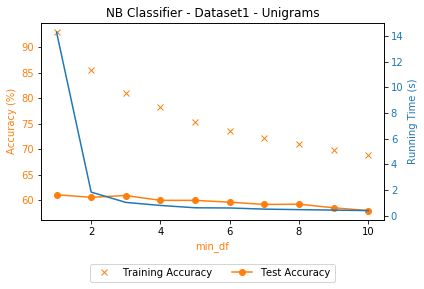

1

In [68]:
nb_experiment(dataset1, "NB Classifier - Dataset1 - Unigrams", 
              'min_df', list(range(1,11)))

- min_df =  1

MultinomialNB Classifier: {}
Feature Extractions: {'min_df': 1}

max_df	Training Acc	Test Acc (%)	Running Time (s)
0.5	  92.937	    61.1	4.59
0.6	  92.937	    61.1	4.64
0.7	  92.937	    61.1	4.49
0.8	  92.937	    61.1	4.33
0.9	  92.937	    61.1	4.64
1.0	  92.937	    61.1	4.55

Highest Accuracy 61.1 with max_df=0.5


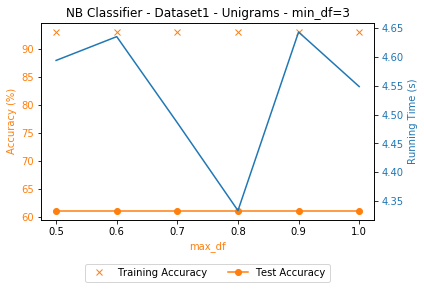

0.5

In [72]:
nb_experiment(dataset1, "NB Classifier - Dataset1 - Unigrams - min_df=3", 
              'max_df', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              {'min_df': 1})

#### Unigrams and bigrams

* First experiment with `min_df` from `[2..10]`.
* Pick `min_df` results the best accuracy.
* Experiment with `max_df` from `[0.5, 0.6, .. 1.0]`

MultinomialNB Classifier: {}
Feature Extractions: {'ngram_range': (1, 2)}

min_df	Training Acc	Test Acc (%)	Running Time (s)
2	  87.086	    61.4	2.20
3	  81.548	    61.7	1.47
4	  78.522	    61.1	1.07
5	  75.672	    60.5	0.89
6	  73.559	    59.8	0.81
7	  72.022	    59.8	0.77
8	  70.921	    59.6	0.71
9	  69.721	    58.8	0.64

Highest Accuracy 61.7 with min_df=3


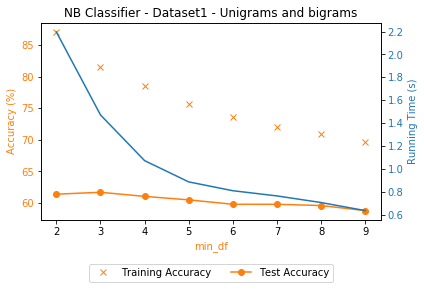

3

In [79]:
nb_experiment(dataset1, "NB Classifier - Dataset1 - Unigrams and bigrams", 
              'min_df', list(range(2,10)),
              {'ngram_range': (1,2)})

- min_df= 3

MultinomialNB Classifier: {}
Feature Extractions: {'ngram_range': (1, 2), 'min_df': 3}

max_df	Training Acc	Test Acc (%)	Running Time (s)
0.5	  81.548	    61.7	1.56
0.6	  81.548	    61.7	1.66
0.7	  81.548	    61.7	1.45
0.8	  81.548	    61.7	1.66
0.9	  81.548	    61.7	1.48
1.0	  81.548	    61.7	1.41

Highest Accuracy 61.7 with max_df=0.5


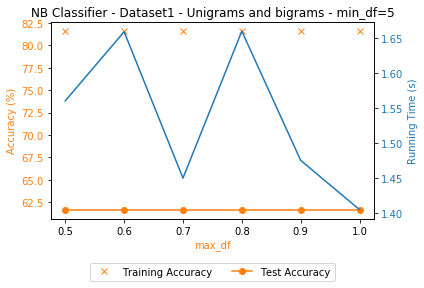

0.5

In [80]:
nb_experiment(dataset1, "NB Classifier - Dataset1 - Unigrams and bigrams - min_df=5", 
              'max_df', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              {'ngram_range': (1,2), 'min_df': 3})

## LogisticRegression

In [81]:
from sklearn.linear_model import LogisticRegression

LogisticRegression_params = {
    'random_state': RANDOM_STATE,
    'solver': 'lbfgs',
    'max_iter': 1000
}

def lr_experiment(ds, title, param_name, param_values, extractor_params={}):
    return run_experiments(ds, title,
                         LogisticRegression, LogisticRegression_params,
                         param_name, param_values, extractor_params)

In [82]:
ds = dataset1

X, y = extract(ds, TfidfVectorizer, {})
experiment(X, y, LogisticRegression, LogisticRegression_params)

Number of features: 32377

Training Accuracy: 0.9399924990623828
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94      2666
     Neutral       0.95      0.91      0.93      2666
    Positive       0.93      0.96      0.95      2667

    accuracy                           0.94      7999
   macro avg       0.94      0.94      0.94      7999
weighted avg       0.94      0.94      0.94      7999


Testing Accuracy: 0.594
              precision    recall  f1-score   support

    Negative       0.58      0.62      0.60       667
     Neutral       0.60      0.52      0.56       667
    Positive       0.61      0.64      0.62       666

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.59      0.59      0.59      2000




(0.9399924990623828, 0.594)

#### Unigrams

* First experiment with `min_df` from `[1..10]`.
* Pick `min_df` results the best accuracy.
* Experiment with `max_df` from `[0.5, 0.6, .. 1.0]`

LogisticRegression Classifier: {'random_state': 33, 'solver': 'lbfgs', 'max_iter': 1000}
Feature Extractions: {}

min_df	Training Acc	Test Acc (%)	Running Time (s)
1	  93.999	    59.4	61.23
2	  88.799	    59.2	33.18
3	  85.336	    59.7	20.94
4	  82.573	    59.5	13.47
5	  79.835	    59.5	10.80
6	  77.672	    58.3	8.01
7	  76.010	    58.0	6.50
8	  74.534	    57.8	5.15
9	  73.097	    57.1	5.75
10	  71.796	    57.0	4.64

Highest Accuracy 59.7 with min_df=3


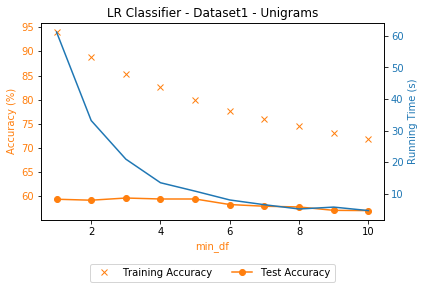

3

In [83]:
lr_experiment(dataset1, "LR Classifier - Dataset1 - Unigrams", 
              'min_df', list(range(1, 11)))

- min_df = 3

LogisticRegression Classifier: {'random_state': 33, 'solver': 'lbfgs', 'max_iter': 1000}
Feature Extractions: {'min_df': 3}

max_df	Training Acc	Test Acc (%)	Running Time (s)
0.5	  85.336	    59.7	22.08
0.6	  85.336	    59.7	23.99
0.7	  85.336	    59.7	22.78
0.8	  85.336	    59.7	20.76
0.9	  85.336	    59.7	19.64
1.0	  85.336	    59.7	19.25

Highest Accuracy 59.7 with max_df=0.5


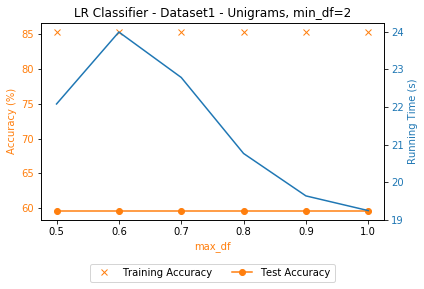

0.5

In [84]:
lr_experiment(dataset1, "LR Classifier - Dataset1 - Unigrams, min_df=2", 
              'max_df', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              {'min_df': 3})

#### Unigrams and bigrams

* First experiment with `min_df` from `[1..10]`.
* Pick `min_df` results the best accuracy.
* Experiment with `max_df` from `[0.5, 0.6, .. 1.0]`

LogisticRegression Classifier: {'random_state': 33, 'solver': 'lbfgs', 'max_iter': 1000}
Feature Extractions: {'ngram_range': (1, 2)}

min_df	Training Acc	Test Acc (%)	Running Time (s)
2	  90.274	    60.6	31.80
3	  86.311	    59.9	17.89
4	  83.760	    60.1	14.97
5	  80.760	    59.2	10.84
6	  78.360	    58.2	10.25
7	  76.560	    58.1	8.63
8	  75.059	    58.2	6.62
9	  73.697	    57.3	6.34
10	  72.284	    57.6	5.34

Highest Accuracy 60.6 with min_df=2


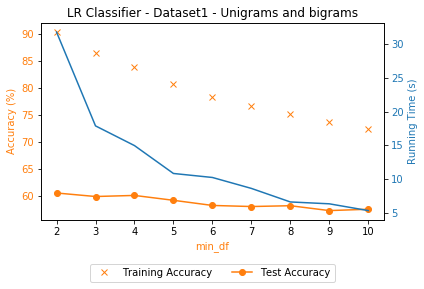

2

In [86]:
lr_experiment(dataset1, "LR Classifier - Dataset1 - Unigrams and bigrams", 
              'min_df', list(range(2, 11)),
              {'ngram_range': (1,2)})

- min_df=2

LogisticRegression Classifier: {'random_state': 33, 'solver': 'lbfgs', 'max_iter': 1000}
Feature Extractions: {'min_df': 2, 'ngram_range': (1, 2)}

max_df	Training Acc	Test Acc (%)	Running Time (s)
0.5	  90.274	    60.6	42.24
0.6	  90.274	    60.6	46.23
0.7	  90.274	    60.6	38.21
0.8	  90.274	    60.6	40.59
0.9	  90.274	    60.6	33.25
1.0	  90.274	    60.6	33.11

Highest Accuracy 60.6 with max_df=0.5


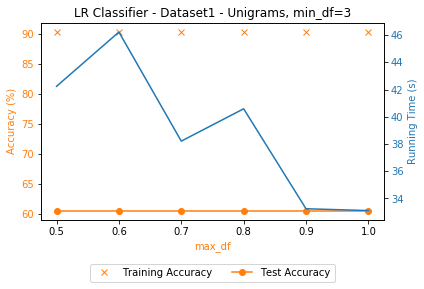

0.5

In [87]:
lr_experiment(dataset1, "LR Classifier - Dataset1 - Unigrams, min_df=3", 
              'max_df', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              {'min_df': 2, 'ngram_range': (1,2)})

## SelectKBest

The best accuracy so far is 61.7.3% which is achieved with:

* NB classifier
* TfidfVectorizer with unigrams and bigrams, `min_df=3` and `max_df=0.5`

Now applying `SelectKBest` after TF-IDF features to seleck `k` best features.

In [88]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

TfidfVectorizer_params = {
    'ngram_range': (1,2), 
    'min_df': 3, 
    'max_df': 0.5
}

def kbest_experiment(ds, title, param_name, param_values, kbest_params={}):
  train_accuracies = []
  test_accuracies = []
  running_times = []
  
  best_accuracy = 0
  best_param = None

  print("MultinomialNB Classifier:")
  print("SelectKBest:", kbest_params)
  print()

  print(f"{param_name}\tTraining Acc\tTest Acc (%)\tRunning Time (s)")

  for value in param_values:
    start_time = time.time()

    X, y = extract(ds, TfidfVectorizer, TfidfVectorizer_params)
    
    kbest_params[param_name] = value
    X = SelectKBest(**kbest_params).fit_transform(X, y)

    train_acc, test_acc = experiment(X, y, MultinomialNB, {}, show_result=False)
    train_acc = train_acc * 100 # percentage
    test_acc = test_acc * 100   # percentage

    running_time = (time.time() - start_time)
    print(f"{value}\t{train_acc:8.3f}\t{test_acc:8.1f}\t{running_time:4.2f}")

    if test_acc > best_accuracy:
      best_accuracy = test_acc
      best_param = value

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    running_times.append(running_time)

  print()
  print(f"Highest Accuracy {best_accuracy:.1f} with {param_name}={best_param}")
  print()
  
  plot_accuracies(param_values,
                  train_accuracies, test_accuracies, running_times,
                  title, param_name) 

MultinomialNB Classifier:
SelectKBest: {'score_func': <function chi2 at 0x0000013E1325BA60>}

k	Training Acc	Test Acc (%)	Running Time (s)
500	  59.832	    56.9	1.50
1000	  65.233	    61.8	1.68
1500	  68.409	    64.4	1.89
2000	  70.884	    66.3	2.16
2500	  72.684	    66.9	2.32
3000	  73.909	    67.9	2.49
3500	  75.284	    67.8	3.15
4000	  76.435	    68.1	2.82
4500	  77.710	    67.5	3.13
5000	  78.785	    67.0	3.30
5500	  79.485	    67.0	3.40
6000	  79.785	    66.6	3.58
6500	  80.323	    66.1	3.85
7000	  80.698	    65.1	4.25
7500	  81.185	    63.5	4.32
8000	  81.485	    62.2	5.38

Highest Accuracy 68.1 with k=4000



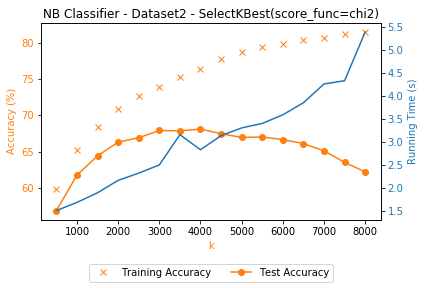

In [89]:
from sklearn.feature_selection import chi2

kbest_experiment(dataset1, "NB Classifier - Dataset1 - SelectKBest(score_func=chi2)",
                 'k', list(range(500, 8001, 500)),
                 {'score_func': chi2 })

MultinomialNB Classifier:
SelectKBest: {'score_func': <function f_classif at 0x0000013E1325B9D8>}

k	Training Acc	Test Acc (%)	Running Time (s)
500	  59.857	    56.3	2.70
1000	  64.883	    61.5	2.98
1500	  67.296	    62.9	2.84
2000	  69.271	    64.5	3.04
2500	  71.034	    66.8	3.23
3000	  73.372	    67.0	3.12
3500	  74.459	    67.8	4.48
4000	  75.522	    68.0	3.52
4500	  76.947	    67.7	3.69
5000	  78.210	    67.3	3.92
5500	  78.997	    67.0	4.79
6000	  79.472	    66.8	5.74
6500	  79.985	    66.1	5.54
7000	  80.760	    65.1	5.05
7500	  81.110	    63.6	5.96
8000	  81.473	    62.2	5.21

Highest Accuracy 68.0 with k=4000



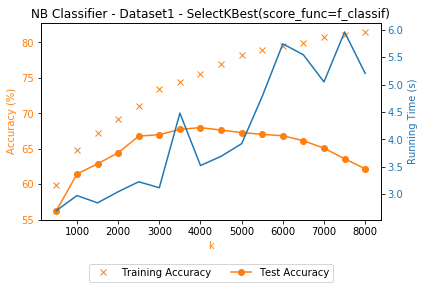

In [90]:
from sklearn.feature_selection import f_classif

kbest_experiment(dataset1, "NB Classifier - Dataset1 - SelectKBest(score_func=f_classif)",
                 'k', list(range(500, 8001, 500)),
                 {'score_func': f_classif })

- Highest Accuracy 68% with k=4000

In [107]:

#kbest_params={}
TfidfVectorizer_params = {
    'ngram_range': (1,2), 
    'min_df': 3, 
    'max_df': 0.5
}
cv = TfidfVectorizer(TfidfVectorizer_params)
X = cv.fit_transform(dataset1.text.values).toarray()
y = dataset1.sentiment.values

#X, y = extract(dataset3, TfidfVectorizer, TfidfVectorizer_params)
  

selector = SelectKBest(chi2, k=4000)
X = selector.fit_transform(X, y)

C:\Users\walsa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass input={'ngram_range': (1, 2), 'min_df': 3, 'max_df': 0.5} as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [108]:

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=22, 
                                                      stratify=y)

cls = MultinomialNB()
cls.fit(X_train, y_train)

y_train_pred = cls.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

y_test_pred = cls.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)


In [110]:
train_acc

0.7683460432554069

In [109]:
test_acc

0.689

In [111]:
tf1_new = TfidfVectorizer(vocabulary = cv.vocabulary_)

In [112]:
xx_new = tweet2['text'].values

In [113]:
X_tf1 = tf1_new.fit_transform(xx_new)

In [114]:
X_test_clean = selector.transform(X_tf1)


In [116]:
pred = cls.predict(X_test_clean)
pred

array(['Positive', 'Positive', 'Positive', ..., 'Neutral', 'Negative',
       'Neutral'], dtype='<U8')

In [117]:
len(pred)

32001

In [121]:
tweet2.shape

(32001, 3)

In [122]:
from sklearn.metrics import classification_report
print(classification_report(tweet2.sentiment, pred))

              precision    recall  f1-score   support

    Negative       0.41      0.73      0.52      4806
     Neutral       0.93      0.55      0.69     22275
    Positive       0.38      0.79      0.51      4920

    accuracy                           0.61     32001
   macro avg       0.57      0.69      0.57     32001
weighted avg       0.77      0.61      0.64     32001



## Neural Networks (Deep Learning)


In this section, we applied a Deep Learning algorithm, by applied the following steps: 
- import a deep learning algorithm.
- define the utilized layers
- compile our model.
- train our model
- evaluate our model.

In [27]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.
C:\Users\walsa\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\walsa\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\walsa\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\walsa\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [32]:
dataset1['sentiment'] = dataset1['sentiment'].astype('str').values
dataset1['sentiment'] = dataset1['sentiment'].astype('category').values
dataset1['sentiment'] = dataset1['sentiment'].cat.codes
dataset1['sentiment'].value_counts()

2    3333
1    3333
0    3333
Name: sentiment, dtype: int64

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer


X = dataset1.text.values
y = dataset1.sentiment.values
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=0.2, 
                                                      random_state=33, 
                                                      stratify=y)


vectorizer = TfidfVectorizer(stop_words=stopwords.words('arabic'))
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [34]:
input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

In [35]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                277470    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 277,503
Trainable params: 277,503
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=100)

Train on 7999 samples, validate on 2000 samples
Epoch 1/10
7999/7999 [==============================] - 4s 522us/step - loss: 1.0929 - acc: 0.4779 - val_loss: 1.0831 - val_acc: 0.5770
Epoch 2/10
7999/7999 [==============================] - 4s 449us/step - loss: 1.0523 - acc: 0.7352 - val_loss: 1.0529 - val_acc: 0.6020
Epoch 3/10
7999/7999 [==============================] - 4s 455us/step - loss: 0.9795 - acc: 0.8246 - val_loss: 1.0125 - val_acc: 0.6050
Epoch 4/10
7999/7999 [==============================] - 4s 443us/step - loss: 0.8793 - acc: 0.8792 - val_loss: 0.9659 - val_acc: 0.6055
Epoch 5/10
7999/7999 [==============================] - 4s 446us/step - loss: 0.7558 - acc: 0.9086 - val_loss: 0.9173 - val_acc: 0.6015
Epoch 6/10
7999/7999 [==============================] - 4s 450us/step - loss: 0.6189 - acc: 0.9346 - val_loss: 0.8779 - val_acc: 0.6080
Epoch 7/10
7999/7999 [==============================] - 4s 469us/step - loss: 0.4874 - acc: 0.9480 - val_loss: 0.8552 - val_acc: 0.6055


In [37]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9847
Testing Accuracy:  0.6090


In [38]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

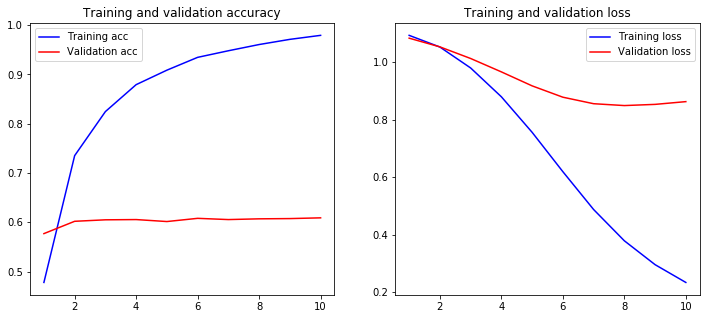

In [39]:
plot_history(history)
